# Data Analysis Notebook
Importación de librería pandas


In [1]:
import pandas as pd

Lectura de ficheros de datos en formato csv

In [2]:
wind_ava=pd.read_csv('wind_ava.csv.gz', compression = "gzip")

wind_comp=pd.read_csv('wind_comp.csv.gz', compression = "gzip")

Visualización de las primeras muestras de datos de los ficheros iniciales

In [3]:
wind_ava.head()

,datetime,energy,p54.162.1,p54.162.2,p54.162.3,p54.162.4,p54.162.5,p54.162.6,p54.162.7,p54.162.8,...,v100.16,v100.17,v100.18,v100.19,v100.20,v100.21,v100.22,v100.23,v100.24,v100.25
0,2005-01-02 18:00:00,402.71,2.534970e+06,2.526864e+06,2.518754e+06,2.510648e+06,2.502537e+06,2.531111e+06,2.522721e+06,2.514330e+06,...,-4.683596,-4.545396,-4.407196,-4.268996,-4.131295,-4.669626,-4.528932,-4.388736,-4.248540,-4.107846
1,2005-01-03 00:00:00,696.80,2.537369e+06,2.529277e+06,2.521184e+06,2.513088e+06,2.504995e+06,2.533465e+06,2.525088e+06,2.516716e+06,...,-3.397886,-3.257192,-3.115998,-2.975304,-2.834609,-3.396390,-3.254198,-3.112506,-2.970314,-2.828622
2,2005-01-03 06:00:00,1591.15,2.533727e+06,2.525703e+06,2.517678e+06,2.509654e+06,2.501629e+06,2.529801e+06,2.521496e+06,2.513187e+06,...,-1.454105,-1.296447,-1.138290,-0.980134,-0.822476,-1.459094,-1.302933,-1.147271,-0.991110,-0.834949
3,2005-01-03 12:00:00,1338.62,2.534491e+06,2.526548e+06,2.518609e+06,2.510670e+06,2.502732e+06,2.530569e+06,2.522346e+06,2.514127e+06,...,1.255015,1.370265,1.485515,1.600765,1.716015,1.210612,1.319376,1.428140,1.536405,1.645169
4,2005-01-03 18:00:00,562.50,2.529543e+06,2.521623e+06,2.513702e+06,2.505782e+06,2.497861e+06,2.525621e+06,2.517421e+06,2.509215e+06,...,1.939031,2.023847,2.108663,2.193977,2.278793,1.873673,1.953000,2.031829,2.111157,2.189986


Las variables son series de tiempo (tenemos la variable *datetime*).
Si modificamos el índice para que este sea la variable *datetime* nos será más simple operar con ello.

In [4]:
wind_ava = wind_ava.set_index('datetime')
wind_ava.head()

,energy,p54.162.1,p54.162.2,p54.162.3,p54.162.4,p54.162.5,p54.162.6,p54.162.7,p54.162.8,p54.162.9,...,v100.16,v100.17,v100.18,v100.19,v100.20,v100.21,v100.22,v100.23,v100.24,v100.25
datetime,,,,,,,,,,,,,,,,,,,,,
2005-01-02 18:00:00,402.71,2.534970e+06,2.526864e+06,2.518754e+06,2.510648e+06,2.502537e+06,2.531111e+06,2.522721e+06,2.514330e+06,2.505940e+06,...,-4.683596,-4.545396,-4.407196,-4.268996,-4.131295,-4.669626,-4.528932,-4.388736,-4.248540,-4.107846
2005-01-03 00:00:00,696.80,2.537369e+06,2.529277e+06,2.521184e+06,2.513088e+06,2.504995e+06,2.533465e+06,2.525088e+06,2.516716e+06,2.508339e+06,...,-3.397886,-3.257192,-3.115998,-2.975304,-2.834609,-3.396390,-3.254198,-3.112506,-2.970314,-2.828622
2005-01-03 06:00:00,1591.15,2.533727e+06,2.525703e+06,2.517678e+06,2.509654e+06,2.501629e+06,2.529801e+06,2.521496e+06,2.513187e+06,2.504882e+06,...,-1.454105,-1.296447,-1.138290,-0.980134,-0.822476,-1.459094,-1.302933,-1.147271,-0.991110,-0.834949
2005-01-03 12:00:00,1338.62,2.534491e+06,2.526548e+06,2.518609e+06,2.510670e+06,2.502732e+06,2.530569e+06,2.522346e+06,2.514127e+06,2.505904e+06,...,1.255015,1.370265,1.485515,1.600765,1.716015,1.210612,1.319376,1.428140,1.536405,1.645169
2005-01-03 18:00:00,562.50,2.529543e+06,2.521623e+06,2.513702e+06,2.505782e+06,2.497861e+06,2.525621e+06,2.517421e+06,2.509215e+06,2.501015e+06,...,1.939031,2.023847,2.108663,2.193977,2.278793,1.873673,1.953000,2.031829,2.111157,2.189986



Actualmente, el fichero tiene 551 columnas. No las necesitamos todas: sólo usaremos la información sobre la localización de Sotavento, es decir, el número 13 de la cuadrícula de 5x5. 

A continuación, modificamos el fichero de datos para eliminar las columnas que no necesitamos y quedarnos únicamente con las columnas de variables relativas a la posición 13 de la cuadrícula. Para ello, filtramos las columnas según aquellas que contengan el número 13 en su nombre.
Además, nos interesa saber el valor de la energía en cada momento en esa localización, por lo que también filtraremos de forma que no se elimine la variable 'energy'.

In [5]:
for c in wind_ava.columns:
    if not c.endswith('.13') and c != 'energy':
        wind_ava = wind_ava.drop(c, axis = 1)

In [6]:
wind_ava.head()

,energy,p54.162.13,p55.162.13,cape.13,p59.162.13,lai_lv.13,lai_hv.13,u10n.13,v10n.13,sp.13,...,t2m.13,stl2.13,stl3.13,iews.13,inss.13,stl4.13,fsr.13,flsr.13,u100.13,v100.13
datetime,,,,,,,,,,,,,,,,,,,,,
2005-01-02 18:00:00,402.71,2.510824e+06,9.186295,13.527577,1.386937e+06,2.344111,2.432983,-0.757587,-1.922799,99846.319914,...,280.473098,281.042026,281.462478,-0.057958,-0.138650,284.684755,0.404731,-5.927092,-1.780562,-4.443617
2005-01-03 00:00:00,696.80,2.513173e+06,8.849569,6.896412,1.153526e+06,2.343719,2.432838,-1.412620,-1.403011,99917.733093,...,278.286616,280.747406,281.486541,-0.103576,-0.083050,284.667948,0.404920,-5.913881,-3.743344,-3.129469
2005-01-03 06:00:00,1591.15,2.509627e+06,7.924080,4.774439,1.098754e+06,2.343300,2.432704,-2.290185,-0.754580,99764.378681,...,277.206490,280.114863,281.487095,-0.165721,-0.036241,284.651914,0.405704,-5.908272,-5.097203,-1.157748
2005-01-03 12:00:00,1338.62,2.510571e+06,6.922709,0.000000,1.076021e+06,2.342830,2.432514,-3.497855,1.271028,99672.670459,...,280.926600,279.991138,281.472435,-0.275550,0.098192,284.636266,0.403967,-5.961995,-4.500835,1.502478
2005-01-03 18:00:00,562.50,2.505664e+06,6.646282,0.000000,1.070830e+06,2.342437,2.432369,-0.971249,0.553060,99372.811211,...,277.363875,280.576898,281.473265,-0.056553,0.041844,284.620232,0.403808,-5.987860,-3.392324,2.131114


Como se puede observar, hemos pasado de operar con 551 columnas, a tener sólo 23 columnas en nuestro dataset.

## Descripción general de los datos

In [7]:
wind_ava

,energy,p54.162.13,p55.162.13,cape.13,p59.162.13,lai_lv.13,lai_hv.13,u10n.13,v10n.13,sp.13,...,t2m.13,stl2.13,stl3.13,iews.13,inss.13,stl4.13,fsr.13,flsr.13,u100.13,v100.13
datetime,,,,,,,,,,,,,,,,,,,,,
2005-01-02 18:00:00,402.71,2.510824e+06,9.186295,13.527577,1.386937e+06,2.344111,2.432983,-0.757587,-1.922799,99846.319914,...,280.473098,281.042026,281.462478,-0.057958,-0.138650,284.684755,0.404731,-5.927092,-1.780562,-4.443617
2005-01-03 00:00:00,696.80,2.513173e+06,8.849569,6.896412,1.153526e+06,2.343719,2.432838,-1.412620,-1.403011,99917.733093,...,278.286616,280.747406,281.486541,-0.103576,-0.083050,284.667948,0.404920,-5.913881,-3.743344,-3.129469
2005-01-03 06:00:00,1591.15,2.509627e+06,7.924080,4.774439,1.098754e+06,2.343300,2.432704,-2.290185,-0.754580,99764.378681,...,277.206490,280.114863,281.487095,-0.165721,-0.036241,284.651914,0.405704,-5.908272,-5.097203,-1.157748
2005-01-03 12:00:00,1338.62,2.510571e+06,6.922709,0.000000,1.076021e+06,2.342830,2.432514,-3.497855,1.271028,99672.670459,...,280.926600,279.991138,281.472435,-0.275550,0.098192,284.636266,0.403967,-5.961995,-4.500835,1.502478
2005-01-03 18:00:00,562.50,2.505664e+06,6.646282,0.000000,1.070830e+06,2.342437,2.432369,-0.971249,0.553060,99372.811211,...,277.363875,280.576898,281.473265,-0.056553,0.041844,284.620232,0.403808,-5.987860,-3.392324,2.131114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-12-30 06:00:00,1280.13,2.385772e+06,14.413342,24.971074,3.905586e+06,2.349839,2.434994,4.595786,5.563189,95460.434452,...,280.731326,282.643490,281.676560,0.628948,0.879581,286.013271,0.424510,-5.715421,6.922743,9.179816
2009-12-30 12:00:00,855.00,2.385708e+06,12.802883,60.248874,2.745694e+06,2.349446,2.434849,4.894838,5.577096,95663.765406,...,283.310687,282.370909,281.761750,0.740926,0.699769,285.988737,0.424762,-5.732455,7.434887,7.537381
2009-12-30 18:00:00,117.06,2.379049e+06,10.915997,3.145067,2.254171e+06,2.349054,2.434715,0.958361,0.948029,95653.110509,...,281.060085,282.425812,281.841961,0.109802,0.125174,285.968452,0.415132,-5.866856,3.033799,3.568993


In [8]:
df_shape = wind_ava.shape
df_shape

(4748, 23)

Nuestro dataset tiene 23 características y 4748 instancias.

In [9]:
df_description = wind_ava.describe()
df_description

,energy,p54.162.13,p55.162.13,cape.13,p59.162.13,lai_lv.13,lai_hv.13,u10n.13,v10n.13,sp.13,...,t2m.13,stl2.13,stl3.13,iews.13,inss.13,stl4.13,fsr.13,flsr.13,u100.13,v100.13
count,4748.000000,4.748000e+03,4748.000000,4748.000000,4.748000e+03,4748.000000,4748.000000,4748.000000,4748.000000,4748.000000,...,4748.000000,4748.000000,4748.000000,4748.000000,4748.000000,4748.000000,4748.000000,4748.000000,4748.000000,4748.000000
mean,693.126247,2.489477e+06,16.008810,31.166541,1.706692e+06,2.815222,2.576284,0.386215,0.120528,97820.301287,...,285.689253,286.663838,286.665988,0.074229,0.049971,286.668152,0.413677,-5.908467,0.447175,0.328204
std,665.531609,4.482599e+04,6.552216,121.758977,1.466953e+06,0.397377,0.116434,3.100583,3.016766,713.689654,...,6.163483,5.547947,4.582827,0.367013,0.379014,3.552873,0.007602,0.094359,4.841730,4.667552
min,0.010000,2.358748e+06,1.650268,0.000000,5.610341e+04,2.323973,2.425866,-8.619823,-8.867441,93770.364813,...,268.970603,275.461648,278.389271,-1.714897,-1.438829,280.875389,0.364805,-6.130465,-11.879053,-13.043453
25%,144.170000,2.458543e+06,11.203264,0.000000,6.563209e+05,2.425944,2.461630,-1.950008,-2.050920,97459.369264,...,281.458939,282.287394,282.689506,-0.126880,-0.148495,283.405549,0.410027,-5.977599,-3.836853,-3.256194
50%,465.305000,2.490478e+06,15.543441,1.004148,1.239176e+06,2.758857,2.560520,0.048820,-0.191853,97861.147677,...,285.395453,286.191880,286.204914,0.010551,-0.003569,286.591659,0.410917,-5.947220,0.282399,-0.389416
75%,1089.375000,2.525134e+06,20.214077,14.143328,2.296548e+06,3.205385,2.688526,2.641779,2.016289,98251.478418,...,289.740438,291.345311,290.989045,0.232378,0.172325,290.024705,0.417070,-5.858848,4.187953,3.614395
max,2792.550000,2.580387e+06,39.230807,2311.662152,1.110694e+07,3.450745,2.762992,12.974802,11.699814,99917.733093,...,305.000640,299.556292,295.639998,2.842552,2.366522,292.808658,0.428914,-5.618172,18.964137,16.913033


Con esta información resumida sobre los datos disponibles podemos averiguar la media, el mínimo y el máximo y la desviación típica de cada variable, entre otras cosas.

Podemos observar además, que todas nuestras variables son numéricas. 

# Preprocesado de datos
En primer lugar, queremos identificar y eliminar los datos faltantes en nuestro dataset, es decir, aquellos que son *NA*.
Para ello identificamos el número de datos faltantes por cada característica.

In [10]:
wind_ava.isna().sum()

energy        0
p54.162.13    0
p55.162.13    0
cape.13       0
p59.162.13    0
lai_lv.13     0
lai_hv.13     0
u10n.13       0
v10n.13       0
sp.13         0
stl1.13       0
u10.13        0
v10.13        0
t2m.13        0
stl2.13       0
stl3.13       0
iews.13       0
inss.13       0
stl4.13       0
fsr.13        0
flsr.13       0
u100.13       0
v100.13       0
dtype: int64

Como podemos ver, no hay ningún valor perdido en nuestros datos, por lo que no necesitamos eliminar ninguna característica. Lo habríamos hecho en el caso de que, para alguna característica, más del 80% de los datos fueran faltantes.

A continuación comprobamos que la desviación típica de todas las variables sea diferente de 0, lo que supondría que todas son significativas y aportan valor al modelo. En caso de que este dato tomara valor nulo supondría que esa variable es constante, y posiblemente se valoraría su eliminación del conjunto de datos.

In [11]:
wind_ava.std()

energy        6.655316e+02
p54.162.13    4.482599e+04
p55.162.13    6.552216e+00
cape.13       1.217590e+02
p59.162.13    1.466953e+06
lai_lv.13     3.973773e-01
lai_hv.13     1.164342e-01
u10n.13       3.100583e+00
v10n.13       3.016766e+00
sp.13         7.136897e+02
stl1.13       6.414325e+00
u10.13        3.158104e+00
v10.13        3.058615e+00
t2m.13        6.163483e+00
stl2.13       5.547947e+00
stl3.13       4.582827e+00
iews.13       3.670135e-01
inss.13       3.790142e-01
stl4.13       3.552873e+00
fsr.13        7.602132e-03
flsr.13       9.435944e-02
u100.13       4.841730e+00
v100.13       4.667552e+00
dtype: float64

## Visualización de los datos
Una vez se ha preprocesado y limpiado el conjunto de los datos, se procede a la creación de diferentes diagramas para recolectar información sobre la distirbución de los datos.
Con un diagrama de barras se pueden apreciar las distribuciones de energía recogidas en cada instante de tiempo (representados como el índice del conjunto de datos).

<AxesSubplot:xlabel='datetime'>

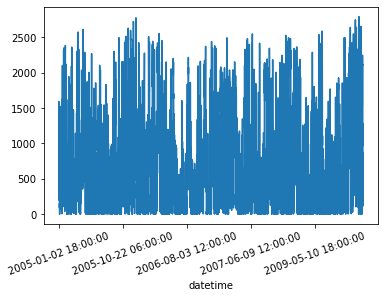

In [18]:
wind_ava['energy'].plot(rot=20)

Para poder identificar información sobre los outliers utilizamos un diagrama de caja o boxplot.

<AxesSubplot:>

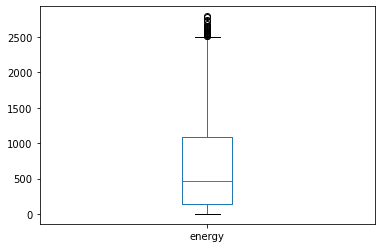

In [19]:
wind_ava['energy'].plot.box()

Se puede observar que hay bastantes outliers de energía generada. A pesar de que la mediana se encuentra alrededor de 500, y el tercer cuartil alrededor de 1000, existen bastantes valores fuera del rango intercuartílico, y todos ellos superando el valor de energía generada de 2500, mientras que por debajo del primer cuartil prácticamente no se percibe la existencia de outliers.

También se puede observar la frecuencia de energía en los diferentes rangos temporales (calulados con el números de divisiones *bins*) mediante un histograma.

<AxesSubplot:ylabel='Frequency'>

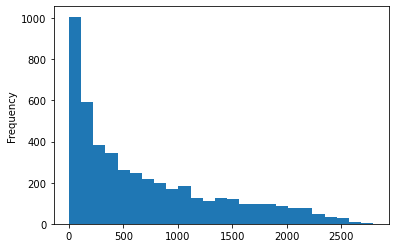

In [26]:
wind_ava['energy'].plot.hist(bins=25)

Se puede observar que la distribución se acumula a la izquierda de los valores temporales. Para solucionar un posible sesgo, se puede convertir la variable *energy* a logarítmica de forma que en el gráfico se aprecie como una distribución normal, en lugar de la actual que asemeja una distribución logarítmica.
Para realizar esta operación, utilizaremos la librería NumPy. Para ello inicialmente importamos la librería mencionada como se muestra a continuación:

In [27]:
import numpy as np

<AxesSubplot:ylabel='Frequency'>

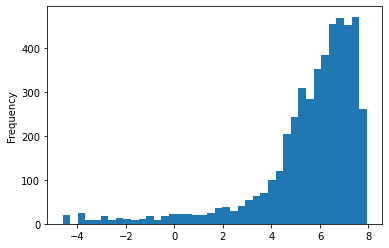

In [33]:
wind_ava['log_energy'] = np.log(wind_ava['energy'])

wind_ava['log_energy'].plot.hist(bins=40)

En este caso, el resultado no es especialmente relevante, ya que la operación convierte un sesgo a la izquierda en un sesgo a la derecha, de forma que el gráfico resultante no asemeja prácticamente una distirbución normal.

# Método de evaluación Outer & Inner
Tras haber estudiado y limpiado el conjunto de datos, se explica la estrategia que se llevará a cabo para evaluar el modelo (*outer*) y para definir el ajuste de hiperparámetros (*inner*).

*`Outer`* 
Para estimar el rendimiento esperado del modelo con datos futuros (para los que no ha sido entrenado), separamos una parte de los datos que apartará para evaluar (test) el modelo resultante del inner.

*`Inner`*
Emplearemos Grid Search con Cross Validation y Time Series Splits.

 